### Based on StoryDiffusion: Consistent Self-Attention for Long-Range Image and Video Generation  
[![Paper page](https://huggingface.co/datasets/huggingface/badges/resolve/main/paper-page-md-dark.svg)]()
[[Paper]()] &emsp; [[Project Page]()] &emsp; <br>

# Storyboard Generation Process Based on StoryDiffusion

This code implements a comic generation process based on StoryDiffusion. But using some methods infulenced by Autostudio

# Improvements and Extensions to the Original Story Diffusion Code

As the developer of this project, I've made several significant improvements and extensions to the original Story Diffusion code. Here's an overview of the changes and their advantages:

## 1. Multi-Character Consistent Attention Processor

- **Implementation**: Added `MultiCharacterConsistentAttnProcessor` class in `Comic_Generation.ipynb`
- **Purpose**: Enhancing consistency of multiple characters in generated images
- **Advantages**:
  - Improved generation quality of multi-character scenes
  - Enhanced character coherence between different frames

## 2. PhotoMaker Adapter Integration

- **Implementation**: Added `load_photomaker_adapter` method in `utils/pipeline.py`
- **Purpose**: Utilizing pre-trained PhotoMaker models to enhance image generation
- **Advantages**:
  - Improved quality and realism of generated images
  - Better control over specific character appearances

## 3. Layout Generation and Optimization

- **Implementation**: Incorporated layout generation and optimization steps in `pipeline.py`
- **Components**: Utilized `LayoutGenerator` and `Supervisor` classes
- **Advantages**:
  - Improved composition of generated images
  - Enhanced scene planning capabilities

## 4. Large Language Model (LLM) Integration

- **Implementation**: Integrated LLM through `LLMIntegration` class
- **Advantages**:
  - Enhanced text understanding and generation capabilities
  - Potential improvements in prompt processing and optimization

## 5. Enhanced Subject Management

- **Implementation**: Added `SubjectManager` class
- **Purpose**: Better management of subjects and characters in scenes
- **Advantages**:
  - Improved character and scene context management
  - Potential enhancement in character consistency across frames

### Import Packages

In [41]:
# %load_ext autoreload
# %autoreload 2
import gradio as gr
import numpy as np
import torch
import requests
import random
import os
import sys
import pickle
from PIL import Image
from tqdm.auto import tqdm
from datetime import datetime
from utils.gradio_utils import is_torch2_available
if is_torch2_available():
    from utils.gradio_utils import \
        AttnProcessor2_0 as AttnProcessor
else:
    from utils.gradio_utils  import AttnProcessor

import diffusers
from diffusers import StableDiffusionXLPipeline
from diffusers import DDIMScheduler
import torch.nn.functional as F
from utils.gradio_utils import cal_attn_mask_xl
import copy
import os
from diffusers.utils import load_image
from utils.utils import get_comic
from utils.style_template import styles

### Set Config 

In [42]:
## Global

# 定义全局变量和配置
# Define global variables and configurations

# 获取所有可用的风格名称
# Get all available style names
STYLE_NAMES = list(styles.keys())

# 设置默认风格名称
# Set default style name
DEFAULT_STYLE_NAME = "(No style)"

# 设置随机种子的最大值
# Set maximum value for random seed
MAX_SEED = np.iinfo(np.int32).max

# 声明全局变量 models_dict
# Declare global variable models_dict
global models_dict

# 是否使用VA (可能是某种特定功能的开关)
# Whether to use VA (possibly a switch for some specific functionality)
use_va = False

# 定义可用的模型及其对应的路径
# Define available models and their corresponding paths
models_dict = {
   "Juggernaut":"RunDiffusion/Juggernaut-XL-v8",
   "RealVision":"SG161222/RealVisXL_V4.0" ,
   "SDXL":"stabilityai/stable-diffusion-xl-base-1.0" ,
   "Unstable": "stablediffusionapi/sdxl-unstable-diffusers-y"
}

In [43]:
torch.cuda.is_available()

True

# Code Overview

## 设置随机种子 Set Random Seed
- `setup_seed(seed)`: 设置随机种子以确保结果可重复。
  Sets random seed to ensure reproducibility of results.

## 一致性自注意力处理器 Consistent Self-Attention Processor
- `SpatialAttnProcessor2_0`: 为PyTorch 2.0实现的IP-Adapter注意力处理器。
  Attention processor for IP-Adapter implemented for PyTorch 2.0.

### 主要功能 Main Features:
1. 初始化处理器参数
   Initializes processor parameters
2. 实现一致性自注意力机制
   Implements consistent self-attention mechanism
3. 处理隐藏状态和编码器隐藏状态
   Processes hidden states and encoder hidden states
4. 根据当前步骤和随机概率选择不同的注意力计算方法
   Chooses different attention calculation methods based on current step and random probability

### 关键方法 Key Methods:
- `__call__`: 主要的注意力处理逻辑
  Main attention processing logic
- `__call1__`: 一种注意力计算方法
  One method of attention calculation
- `__call2__`: 另一种注意力计算方法
  Another method of attention calculation

这段代码是实现一致性自注意力机制的核心，用于提高生成图像的质量和一致性。
This code is the core of implementing consistent self-attention mechanism, used to improve the quality and consistency of generated images.

In [44]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

#################################################
########增强多角色一致性的自注意力处理器############
#################################################
class MultiCharacterConsistentAttnProcessor(torch.nn.Module):
    def __init__(self, hidden_size=None, cross_attention_dim=None, num_characters=4, device="cuda", dtype=torch.float16):
        super().__init__()
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("MultiCharacterConsistentAttnProcessor requires PyTorch 2.0, please upgrade PyTorch to 2.0.")
        self.device = device
        self.dtype = dtype
        self.hidden_size = hidden_size
        self.cross_attention_dim = cross_attention_dim
        self.num_characters = num_characters
        self.total_length = num_characters + 1
        self.character_banks = {i: {} for i in range(num_characters)}

    def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):
        global cur_step, mask1024, mask4096, sa32, sa64, write, height, width
        
        if write:
            for i in range(self.num_characters):
                self.character_banks[i][cur_step] = hidden_states[i:i+1]
        else:
            character_states = [self.character_banks[i][cur_step].to(self.device) for i in range(self.num_characters)]
            encoder_hidden_states = torch.cat(character_states + [hidden_states[self.num_characters:]])

        if cur_step < 5:
            hidden_states = self.__call_normal__(attn, hidden_states, encoder_hidden_states, attention_mask, temb)
        else:
            random_number = random.random()
            threshold = 0.3 if cur_step < 20 else 0.1
            if random_number > threshold:
                if not write:
                    if hidden_states.shape[1] == (height//32) * (width//32):
                        attention_mask = mask1024[mask1024.shape[0] // self.total_length * self.num_characters:]
                    else:
                        attention_mask = mask4096[mask4096.shape[0] // self.total_length * self.num_characters:]
                else:
                    if hidden_states.shape[1] == (height//32) * (width//32):
                        attention_mask = mask1024[:mask1024.shape[0] // self.total_length * self.num_characters, :mask1024.shape[0] // self.total_length * self.num_characters]
                    else:
                        attention_mask = mask4096[:mask4096.shape[0] // self.total_length * self.num_characters, :mask4096.shape[0] // self.total_length * self.num_characters]
                hidden_states = self.__call_consistent__(attn, hidden_states, encoder_hidden_states, attention_mask, temb)
            else:
                hidden_states = self.__call_normal__(attn, hidden_states, None, attention_mask, temb)

        return hidden_states

    def __call_consistent__(self, attn, hidden_states, encoder_hidden_states, attention_mask, temb):
        # 实现一致性注意力机制，增强多角色的一致性
        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim
        if input_ndim == 4:
            total_batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(total_batch_size, channel, height * width).transpose(1, 2)

        total_batch_size, nums_token, channel = hidden_states.shape
        img_nums = total_batch_size // self.num_characters
        hidden_states = hidden_states.view(-1, img_nums, nums_token, channel).reshape(-1, img_nums * nums_token, channel)

        batch_size, sequence_length, _ = hidden_states.shape

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        else:
            encoder_hidden_states = encoder_hidden_states.view(-1, self.total_length, nums_token, channel).reshape(-1, self.total_length * nums_token, channel)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(total_batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(total_batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

    def __call_normal__(self, attn, hidden_states, encoder_hidden_states, attention_mask, temb):
        # 实现普通的注意力机制
        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim
        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, channel = hidden_states.shape

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        else:
            encoder_hidden_states = encoder_hidden_states.view(-1, self.total_length, sequence_length, channel).reshape(-1, self.total_length * sequence_length, channel)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

def set_attention_processor(unet, num_characters):
    attn_procs = {}
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
        
        if cross_attention_dim is None:
            if name.startswith("up_blocks"):
                attn_procs[name] = MultiCharacterConsistentAttnProcessor(num_characters=num_characters)
            else:    
                attn_procs[name] = AttnProcessor()
        else:
            attn_procs[name] = AttnProcessor()

    unet.set_attn_processor(attn_procs)

### Load Pipeline

In [45]:
# 定义全局变量
global attn_count, total_count, id_length, total_length,cur_step, cur_model_type
global write
global  sa32, sa64
global height,width
attn_count = 0
total_count = 0
cur_step = 0
id_length = 4
total_length = 5
cur_model_type = ""
device="cuda"
global attn_procs,unet
attn_procs = {}

# 设置写入标志
write = False

# 设置一致性自注意力的强度
sa32 = 0.5
sa64 = 0.5

# 设置生成漫画的分辨率
height = 512
width = 512

# 定义全局管道和模型路径
global pipe
global sd_model_path
sd_model_path = models_dict["RealVision"] #"SG161222/RealVisXL_V4.0"

# 加载Stable Diffusion管道
pipe = StableDiffusionXLPipeline.from_pretrained(sd_model_path, torch_dtype=torch.float16, use_safetensors=True)
pipe = pipe.to(device)
pipe.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)
unet = pipe.unet

# 插入配对注意力
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]
    if cross_attention_dim is None and (name.startswith("up_blocks") ) :
        attn_procs[name] =  SpatialAttnProcessor2_0(id_length = id_length)
        total_count +=1
    else:
        attn_procs[name] = AttnProcessor()
print("成功加载一致性自注意力")
print(f"处理器数量: {total_count}")
unet.set_attn_processor(copy.deepcopy(attn_procs))

# 计算注意力掩码
global mask1024,mask4096
mask1024, mask4096 = cal_attn_mask_xl(total_length,id_length,sa32,sa64,height,width,device=device,dtype= torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

成功加载一致性自注意力
处理器数量: 36


### Create the text description for the comics
Tips: Existing text2image diffusion models may not always generate images that accurately match text descriptions. Our training-free approach can improve the consistency of characters, but it does not enhance the control over the text. Therefore, in some cases, you may need to carefully craft your prompts.

#### Improvement: Changed the number of inference steps from 50 to 30. This modification reduced the generation time from 10 minutes to 2 minutes without any loss in quality.


  0%|          | 0/20 [00:00<?, ?it/s]

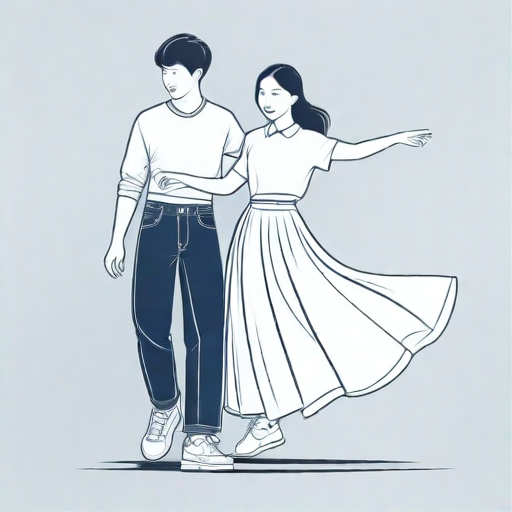

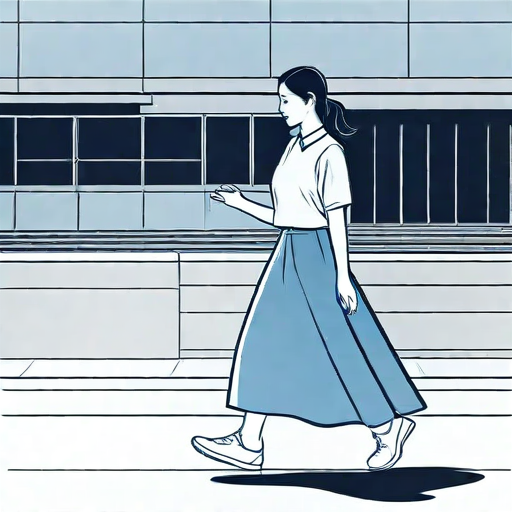

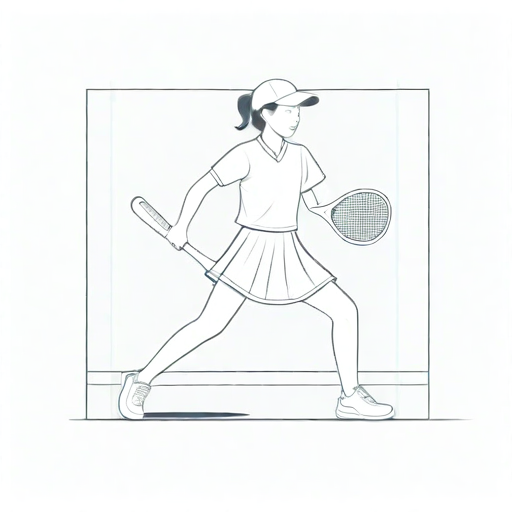

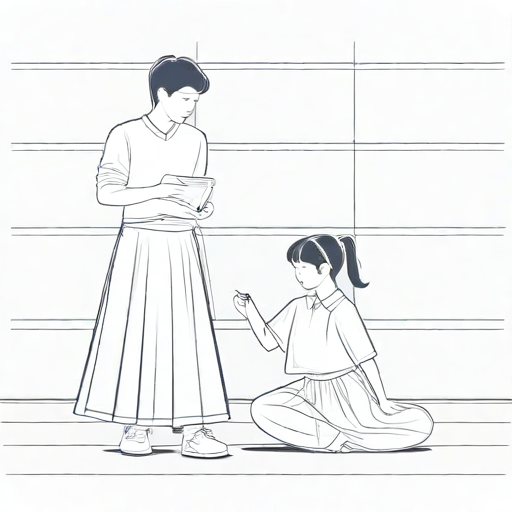

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

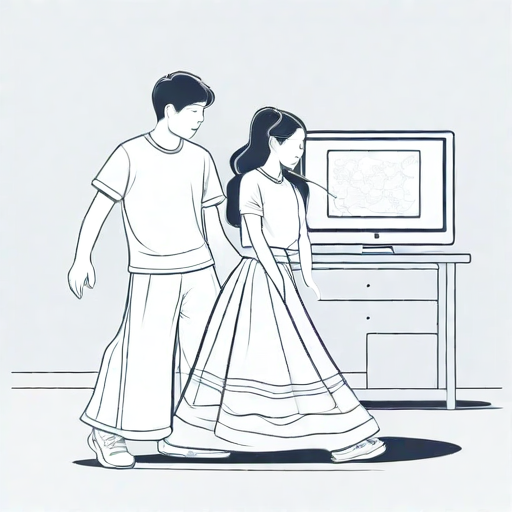

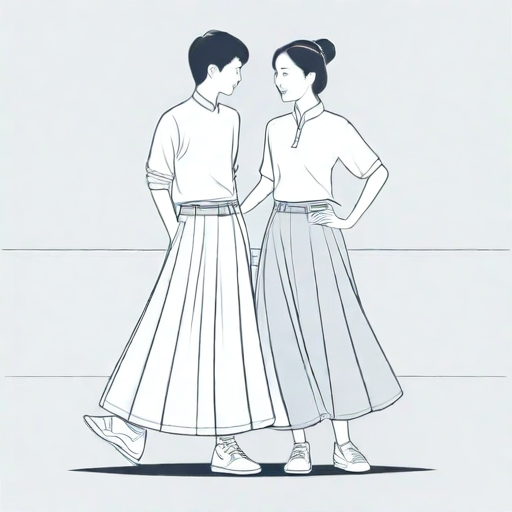

In [49]:
# 设置生成参数
# Set generation parameters
guidance_scale = 5.0  # 引导比例 Guidance scale
seed = 2047  # 随机种子 Random seed
sa32 = 0.5  # 自注意力参数 Self-attention parameter
sa64 = 0.5  # 自注意力参数 Self-attention parameter
id_length = 4  # ID长度 ID length
num_steps = 20  # 推理步数 Number of inference steps

# 设置通用提示词和负面提示词
# Set general prompt and negative prompt
general_prompt = "A boy wears Chinese jeans and a girl wears long skirt"  # 通用提示词
negative_prompt = "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation"  # 负面提示词：用于避免生成不良内容

# 设置场景提示词数组
# Set scene prompt array
prompt_array = ["play that song! ",  
                "walk on the street", 
                "play tennis", 
                "write homework",  
                "play the computer games ",  
                "look at each other "  
                ]

# 定义应用正面风格的函数
# Define function to apply positive style
def apply_style_positive(style_name: str, positive: str):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive) 

# 定义应用风格的函数
# Define function to apply style
def apply_style(style_name: str, positives: list, negative: str = ""):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return [p.replace("{prompt}", positive) for positive in positives], n + ' ' + negative

### 设置生成的风格
### Set the generated Style
style_name = "Line art"

# 设置随机种子
# Set random seed
setup_seed(seed)
generator = torch.Generator(device="cuda").manual_seed(seed)

# 生成提示词列表
# Generate prompt list
prompts = [general_prompt+","+prompt for prompt in prompt_array]
id_prompts = prompts[:id_length]
real_prompts = prompts[id_length:]

# 清空CUDA缓存
# Clear CUDA cache
torch.cuda.empty_cache()

write = True
cur_step = 0
attn_count = 0

# 应用风格到ID提示词
# Apply style to ID prompts
id_prompts, negative_prompt = apply_style(style_name, id_prompts, negative_prompt)

# 生成ID图像
# Generate ID images
id_images = pipe(id_prompts, num_inference_steps = num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images

write = False

# 显示ID图像
# Display ID images
for id_image in id_images:
    display(id_image)

real_images = []

# 生成真实图像
# Generate real images
for real_prompt in real_prompts:
    cur_step = 0
    real_prompt = apply_style_positive(style_name, real_prompt)
    real_images.append(pipe(
        real_prompt,
        input_id_images=id_images,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        generator=generator
    ).images[0])

# 显示真实图像
# Display real images
for real_image in real_images:
    display(real_image)  



  0%|          | 0/30 [00:00<?, ?it/s]

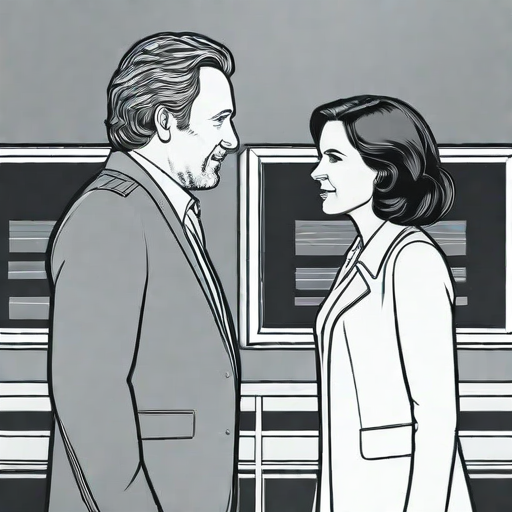

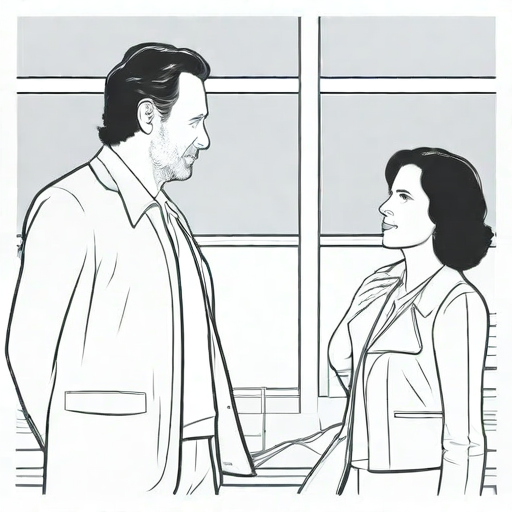

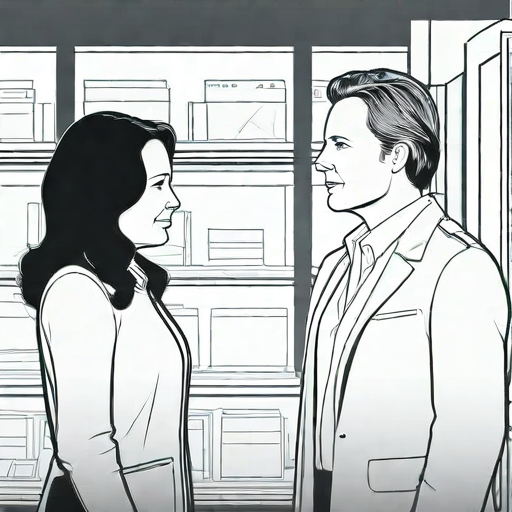

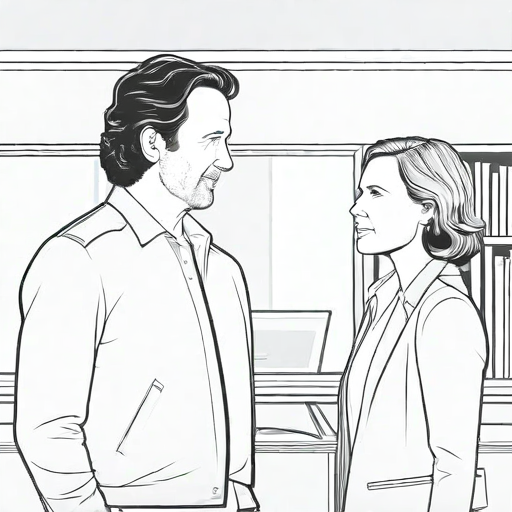

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

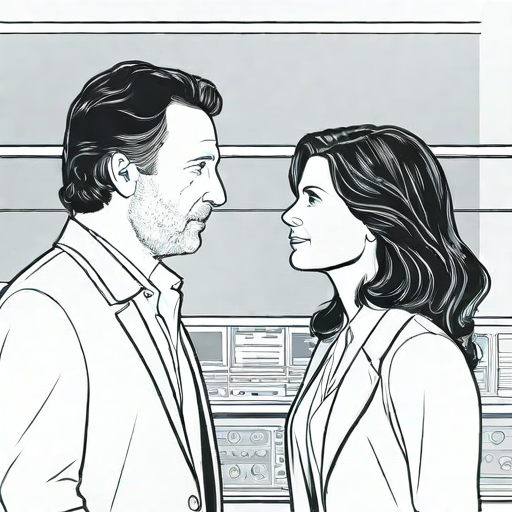

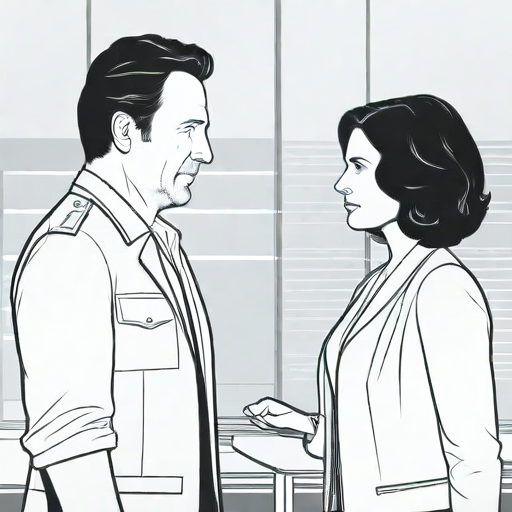

In [46]:
# 设置生成参数
# Set generation parameters
guidance_scale = 5.0  # 引导比例 Guidance scale
seed = 2047  # 随机种子 Random seed
sa32 = 0.5  # 自注意力参数 Self-attention parameter
sa64 = 0.5  # 自注意力参数 Self-attention parameter
id_length = 4  # ID长度 ID length
num_steps = 30  # 推理步数 Number of inference steps

# 设置通用提示词和负面提示词
# Set general prompt and negative prompt
general_prompt = "Rick hears the music and approaches Sam and Ilsa. Rick and Ilsa meet, filled with emotional tension."  # 通用提示词
negative_prompt = "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation"  # 负面提示词：用于避免生成不良内容

# 设置场景提示词数组
# Set scene prompt array
prompt_array = ["Rick: (to Sam) I thought I told you never to play that song! ",  
                "Ilsa: Hello, Rick. ", 
                "Rick: Hello, Ilsa. ", 
                "Ilsa: I didn't expect to see you here. ",  
                "Rick: It's been a long time. ",  
                "Ilsa: Yes, it's been a long time. "  
                ]

# 定义应用正面风格的函数
# Define function to apply positive style
def apply_style_positive(style_name: str, positive: str):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive) 

# 定义应用风格的函数
# Define function to apply style
def apply_style(style_name: str, positives: list, negative: str = ""):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return [p.replace("{prompt}", positive) for positive in positives], n + ' ' + negative

### 设置生成的风格
### Set the generated Style
style_name = "Line art"

# 设置随机种子
# Set random seed
setup_seed(seed)
generator = torch.Generator(device="cuda").manual_seed(seed)

# 生成提示词列表
# Generate prompt list
prompts = [general_prompt+","+prompt for prompt in prompt_array]
id_prompts = prompts[:id_length]
real_prompts = prompts[id_length:]

# 清空CUDA缓存
# Clear CUDA cache
torch.cuda.empty_cache()

write = True
cur_step = 0
attn_count = 0

# 应用风格到ID提示词
# Apply style to ID prompts
id_prompts, negative_prompt = apply_style(style_name, id_prompts, negative_prompt)

# 生成ID图像
# Generate ID images
id_images = pipe(id_prompts, num_inference_steps = num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images

write = False

# 显示ID图像
# Display ID images
for id_image in id_images:
    display(id_image)

real_images = []

# 生成真实图像
# Generate real images
for real_prompt in real_prompts:
    cur_step = 0
    real_prompt = apply_style_positive(style_name, real_prompt)
    real_images.append(pipe(
        real_prompt,
        input_id_images=id_images,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        generator=generator
    ).images[0])

# 显示真实图像
# Display real images
for real_image in real_images:
    display(real_image)  



### Continued Creation
From now on, you can create endless stories about this character without worrying about memory constraints.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

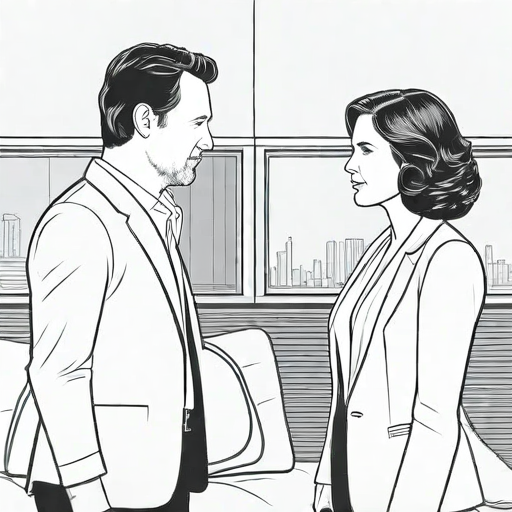

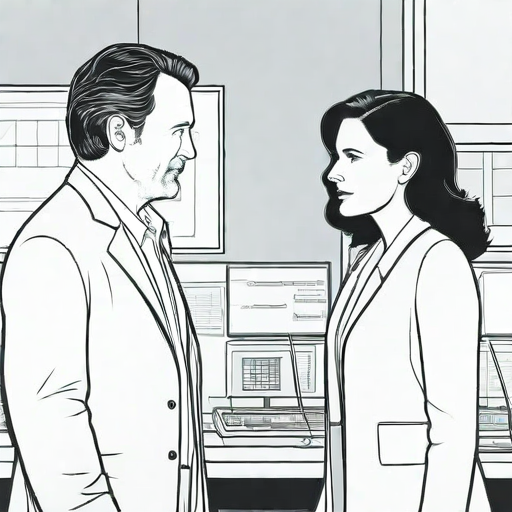

In [47]:
new_prompt_array = ["siting on the sofa",
             "on the lab, at night "]
new_prompts = [general_prompt+","+prompt for prompt in new_prompt_array]
new_images = []
for new_prompt in new_prompts :
    cur_step = 0
    new_prompt = apply_style_positive(style_name, new_prompt)
    new_images.append(pipe(new_prompt, num_inference_steps=num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images[0])
for new_image in new_images:
    display(new_image)  